In [122]:
import numpy as np
import pandas as pd 
import json
import os

In [123]:
data_dir = "../datasets/my_dataset/"

In [124]:
schema_path = os.path.join(data_dir, 'schema.json')
schema = open(schema_path, 'r')
predicate_dict = {}
ners = set()
for l_idx, line in enumerate(schema):
    tmp = json.loads(line)
    predicate_dict[tmp['predicate']] = (tmp['subjtct_type'], tmp['object_type'])
    ners.add(tmp['subjtct_type'])
    ners.add(tmp['object_type'])

In [126]:
print(len(predicate_dict))
predicate_dict

19


{'相关文物': ('遗址文化', '文物藏品'),
 '所在地': ('遗址文化/单位机构', '地点'),
 '所属时代': ('遗址文化/文物藏品/人物', '历史时代'),
 '文物尺寸': ('文物藏品', '尺寸'),
 '面积大小': ('遗址文化/单位机构', '面积'),
 '发现时间': ('遗址文化/文物藏品', '时间'),
 '保存于': ('文物藏品', '单位机构'),
 '建设时间': ('遗址文化', '时间'),
 '文保级别': ('遗址文化', '保护级别'),
 '相关建筑': ('遗址文化', '建筑'),
 '相关人物': ('遗址文化/文物藏品/人物', '人物'),
 '相关单位': ('遗址文化', '单位机构'),
 '馆藏物品': ('单位机构', '文物藏品'),
 '文化类型': ('遗址文化', '文化'),
 '成立时间': ('单位机构', '时间'),
 '文化组成': ('遗址文化', '遗址文化'),
 '相关文献': ('遗址文化/文物藏品', '书籍文献'),
 '文物重量': ('文物藏品', '重量'),
 '馆长': ('单位机构', '人物')}

In [129]:
predicate_dict.keys()

dict_keys(['相关文物', '所在地', '所属时代', '文物尺寸', '面积大小', '发现时间', '保存于', '建设时间', '文保级别', '相关建筑', '相关人物', '相关单位', '馆藏物品', '文化类型', '成立时间', '文化组成', '相关文献', '文物重量', '馆长'])

In [130]:
ners_set = set()
for _, (n1, n2) in predicate_dict.items():
    ners_set.add(n1)
    ners_set.add(n2)

In [131]:
print(len(ners_set))
ners_set

17


{'书籍文献',
 '人物',
 '保护级别',
 '单位机构',
 '历史时代',
 '地点',
 '尺寸',
 '建筑',
 '文化',
 '文物藏品',
 '时间',
 '遗址文化',
 '遗址文化/单位机构',
 '遗址文化/文物藏品',
 '遗址文化/文物藏品/人物',
 '重量',
 '面积'}

In [132]:
import re
# 处理数据

def get_data(file_path, key_word):
    with open(file_path, 'r', encoding='utf-8') as file:
        docs = []
        for l_idx, line in enumerate(file):
            doc = {}
            info = json.loads(line)
            doc['doc_key'] = str(l_idx) + key_word
            ori_sent = info['sentence']
            if len(ori_sent) > 256:
                print(len(ori_sent))
            doc['sentences'] = [[ch for ch in ori_sent]] #TODO split into tokens
            doc['ner'] = [[]]
            doc['relations'] = [[]]
            spos = info['spos']
            entity_set = set()
            for cur_spo in spos:
                cur_rel = cur_spo['p']
                 # 不在schema中 e.g. 馆长
                if cur_rel not in predicate_dict:
                    continue
                s_ner, o_ner = predicate_dict[cur_rel]
                sub = cur_spo['s']
                obj = cur_spo['o']
                sub_start_idx = ori_sent.find(sub)
                sub_end_idx = sub_start_idx + len(sub) - 1
                obj_start_idx = ori_sent.find(obj)
                obj_end_idx = obj_start_idx + len(obj) - 1
                if sub_start_idx != -1:
                    doc['ner'][0].append([sub_start_idx, sub_end_idx, s_ner])
                if obj_start_idx != -1:
                    doc['ner'][0].append([obj_start_idx, obj_end_idx, o_ner])
                if sub_start_idx != -1 and obj_start_idx != -1:

                    doc['relations'][0].append([sub_start_idx, sub_end_idx, obj_start_idx, obj_end_idx, cur_rel])


        #         if sub not in entity_set:
        #             start_indexes = [substr.start() for substr in re.finditer(sub, ori_sent)]
        #             for start_idx in start_indexes:
        #                 end_idx = start_idx + len(sub) - 1 # [start, end]
        #                 doc['ner'][0].append([start_idx, end_idx, s_ner])
        #         if obj not in entity_set:
        #             start_indexes = [substr.start() for substr in re.finditer(obj, ori_sent)]
        #             for start_idx in start_indexes:
        #                 end_idx = start_idx + len(obj) - 1 # [start, end]
        #                 doc['ner'][0].append([start_idx, end_idx, o_ner])

            docs.append(doc)
        return docs



In [133]:
data_processed_dir = "../datasets/my_dataset_processed/"
train_path = os.path.join(data_dir, 'train.json')
train_data = get_data(train_path, 'train')

with open(os.path.join(data_processed_dir, 'train.json'),"w", encoding="utf-8") as f:
    for d in train_data:
        f.write(json.dumps(d, ensure_ascii=False)+'\n')

eval_path = os.path.join(data_dir, 'eval.json')
eval_data = get_data(eval_path, 'eval')

with open(os.path.join(data_processed_dir, 'dev.json'),"w", encoding="utf-8") as f:
    for d in eval_data:
        f.write(json.dumps(d, ensure_ascii=False)+'\n')


288
334
422
346
276
285
289
266
270
272
294
288
284
270
270
262
304
269


In [141]:
count = 0
for doc in eval_data:
    count += len(doc['relations'][0])
count 

742

## baseline

In [112]:
import json
import pandas as pd

examples = []
with open("../datasets/my_dataset/train.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        examples.append(json.loads(i))
train = pd.DataFrame(examples)
train ["idlength"] = [len(i) for i in train ["id"]]
train ["slength"] = [len(i) for i in train ["sentence"]]

examples = []
with open("../datasets/my_dataset/eval.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        examples.append(json.loads(i))
eval = pd.DataFrame(examples)
eval["idlength"] = [len(i) for i in eval["id"]]
eval["slength"] = [len(i) for i in eval["sentence"]]
print(train.shape,eval.shape)

(800, 5) (200, 5)


(<AxesSubplot:>, <AxesSubplot:>)

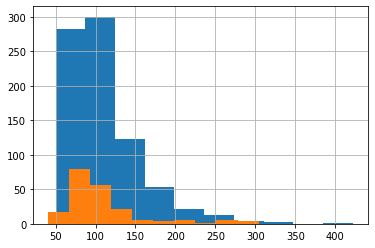

In [115]:
train["slength"].hist(),eval["slength"].hist()

In [118]:

schema_list = []
with open("../datasets/my_dataset/schema.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        schema_list.append(json.loads(i))
schema_list

[{'subjtct_type': '遗址文化', 'predicate': '相关文物', 'object_type': '文物藏品'},
 {'subjtct_type': '遗址文化/单位机构', 'predicate': '所在地', 'object_type': '地点'},
 {'subjtct_type': '遗址文化/文物藏品/人物', 'predicate': '所属时代', 'object_type': '历史时代'},
 {'subjtct_type': '文物藏品', 'predicate': '文物尺寸', 'object_type': '尺寸'},
 {'subjtct_type': '遗址文化/单位机构', 'predicate': '面积大小', 'object_type': '面积'},
 {'subjtct_type': '遗址文化/文物藏品', 'predicate': '发现时间', 'object_type': '时间'},
 {'subjtct_type': '文物藏品', 'predicate': '保存于', 'object_type': '单位机构'},
 {'subjtct_type': '遗址文化', 'predicate': '建设时间', 'object_type': '时间'},
 {'subjtct_type': '遗址文化', 'predicate': '文保级别', 'object_type': '保护级别'},
 {'subjtct_type': '遗址文化', 'predicate': '相关建筑', 'object_type': '建筑'},
 {'subjtct_type': '遗址文化/文物藏品/人物', 'predicate': '相关人物', 'object_type': '人物'},
 {'subjtct_type': '遗址文化', 'predicate': '相关单位', 'object_type': '单位机构'},
 {'subjtct_type': '单位机构', 'predicate': '馆藏物品', 'object_type': '文物藏品'},
 {'subjtct_type': '遗址文化', 'predicate': '文化类型', 'object_type': 

In [120]:
def get_uie_data(df):
    prompt_datas = []
    for idx,rows in df.iterrows():
        text = rows["sentence"]
        spo_list = rows["spos"]
        entitys = []
        relations = []
        for spo in spo_list:
            pso = [(schema["subjtct_type"],schema["object_type"])for schema in schema_list if schema["predicate"] == spo['p']][0]
            if spo['s'] not in entitys:
                entitys.append([spo['s'],pso[0]])
            if spo['o'] not in entitys:
                entitys.append([spo['o'],pso[1]])
            if spo['p'] not in relations:
                relations.append([spo['p'],spo['s'],spo['o']])
        prompt_data = {}
        prompt_data["text"] = rows["sentence"]
        prompt_data["entities"] = []
        prompt_data["relations"] = []
        id_number = 0
        for entity in entitys:
            entity_pre = {}
            entity_pre['id'] = id_number
            entity_pre["start_offset"] = text.index(entity[0])
            entity_pre["end_offset"] = text.index(entity[0])+len(entity[0])
            entity_pre["label"] = entity[1]
            entity_pre["name"] = entity[0]
            prompt_data["entities"].append(entity_pre)
            id_number += 1

        for relation in relations:
            relation_pre = {}
            from_id = [e['id'] for e in prompt_data["entities"] if e['name']==relation[1]][0]
            to_id = [e['id'] for e in prompt_data["entities"] if e['name']==relation[2]][0]
            relation_pre["from_id"] = from_id
            relation_pre["to_id"] = to_id
            relation_pre["type"] = relation[0]
            prompt_data["relations"].append(relation_pre)
        prompt_datas.append(prompt_data)
    return prompt_datas

data = get_uie_data(train)
dev = get_uie_data(eval)

In [145]:




with open('./bert_models/re-roberta-zh-1/pred_results.json','r', encoding = 'utf8') as f:
    for line in f:
        print(json.loads(line))
        break

{'0': [[0, [[[0, 7], [19, 34], '所在地'], [[0, 7], [43, 64], '相关文献'], [[0, 7], [37, 39], '相关人物']]]], '1': [[0, [[[0, 5], [8, 10], '所在地'], [[0, 5], [100, 107], '文保级别'], [[0, 5], [28, 34], '相关文献']]]], '2': [[0, [[[0, 7], [80, 90], '保存于'], [[0, 7], [0, 1], '所属时代'], [[0, 7], [34, 37], '相关文献']]]], '3': [[0, [[[0, 8], [31, 36], '相关文献'], [[0, 8], [26, 30], '发现时间']]]], '4': [[0, [[[0, 7], [18, 29], '所在地'], [[0, 7], [8, 15], '发现时间'], [[0, 7], [70, 77], '文化组成']]]], '5': [[0, [[[0, 7], [10, 15], '所在地'], [[0, 7], [34, 38], '发现时间'], [[0, 7], [3, 4], '相关文物'], [[0, 7], [22, 28], '所属时代']]]], '6': [[0, [[[0, 3], [5, 14], '文保级别'], [[0, 3], [17, 18], '所在地'], [[0, 3], [17, 21], '文化组成'], [[0, 3], [63, 74], '相关单位'], [[17, 21], [5, 14], '文保级别']]]], '7': [[0, [[[9, 13], [0, 5], '所在地'], [[9, 13], [56, 60], '发现时间'], [[9, 13], [49, 54], '面积大小'], [[9, 13], [102, 106], '相关文物'], [[15, 21], [0, 5], '所在地'], [[15, 21], [56, 60], '发现时间'], [[15, 21], [102, 106], '相关文物']]]], '8': [[0, [[[0, 8], [33, 53], '所在地'], [[0, 8], [1